## Project
The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build **a model that predicts if a given user will subscribe to the newsletter**, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

They designed a competition aiming at building a model that allows to predict the *conversions* (i.e. when a user will subscribe to the newsletter). To do so, they open-sourced a dataset containing some data about the traffic on their website. To assess the rankings of the different competing teams, they decided to use the **f1-score**.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
from IPython.display import display

import seaborn as sns
sns.set_theme()

## 1. EDA

In [2]:
data = pd.read_csv('./../data/raw/conversion_data_train.csv')
print('Train data size:', data.shape)

Train data size: (284580, 6)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


> 5 explicatives variables
* 3 numerical: age, new_user, total_pages_visited
* 2 categorical: country, source

> 0 missing values

In [4]:
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Describe data

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Some numbers:
* On average, 4 pages are visited per user \n
* 75 % of all users have visited less than 7 pages
* On average, the age of users is 30 years old

### Categorical variables

In [6]:
# Create a seires with the number of values for country and source
dist_country = data.country.value_counts()
dist_source = data.source.value_counts()
dist_new_user = data.new_user.value_counts()

In [7]:
# Make a funtion to draw pie charts on a subplot object
def draw_pie_chart(title,data, subplot, labels=None):
    labels_to_use = labels if labels is not None else data.index
    subplot.pie(x=data.values, labels=labels_to_use, autopct='%.0f%%');
    subplot.set_title(title)

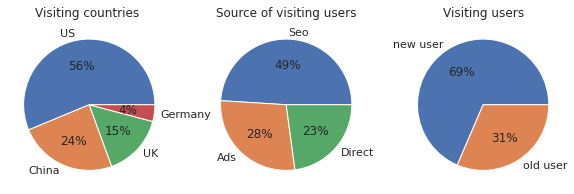

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((10,6)))
draw_pie_chart('Visiting countries ', dist_country, axes[0])
draw_pie_chart('Source of visiting users', dist_source, axes[1])
labels = ['new user', 'old user']
draw_pie_chart('Visiting users', dist_new_user, axes[2], labels)

### Converted users (%)

In [9]:
data['converted'].value_counts()*100/data.shape[0]

0    96.774194
1     3.225806
Name: converted, dtype: float64

<b> /!\ 3% of users that visited the site were converted </b>

### Converted users per country

In [10]:
# Create 2 functions to use in the aggregate calculations

# Function to calculate the number of non-converted visitors
def non_converted(x): return len(x) - x.sum()

#Function to calculate the percentage of converted users
def conversion_percentage(x): return round(x.sum()*100 / len(x),2)

#Group by country, calculate the total users, converted, non-converted and the percentage of converted users
converted_per_country = data.groupby('country', as_index=False).agg(
    total_users=pd.NamedAgg(column="converted", aggfunc=len),
    converted=pd.NamedAgg(column="converted", aggfunc="sum"),
    non_converted=pd.NamedAgg(column="converted", aggfunc=non_converted),
    converted_percentage=pd.NamedAgg(column="converted", aggfunc=conversion_percentage))

In [11]:
#Function to print a label in a graph.  Uses matplotlib's plt.text(x,y,s, ha, va, bbox)
# x,y correspond to values in X and Y coordinates
def valuelabel(x,y):
    for i in range(len(x)):
        #Add 0.2 to the X coordinate because only the converted values are printed.
        plt.text(i+0.2,y[i]+1000,y[i], ha = 'center', fontsize=12)

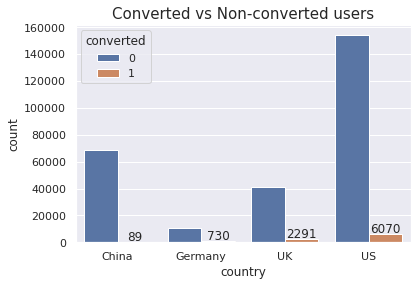

   country  total_users  converted  non_converted  converted_percentage
0    China        69122         89          69033                  0.13
1  Germany        11693        730          10963                  6.24
2       UK        43641       2291          41350                  5.25
3       US       160124       6070         154054                  3.79


In [12]:
sns.countplot(data=data, x="country", hue="converted", order=['China', 'Germany', 'UK', 'US'])
plt.title('Converted vs Non-converted users', fontdict={'fontname':'DejaVu Sans', 'fontsize':15})
valuelabel(converted_per_country['country'],converted_per_country['converted'])
plt.show()
print(converted_per_country)

In [13]:
#Let's work with a sample to visualize date
data_sample = data.sample(10000)


### Relations between variables

<Figure size 720x432 with 0 Axes>

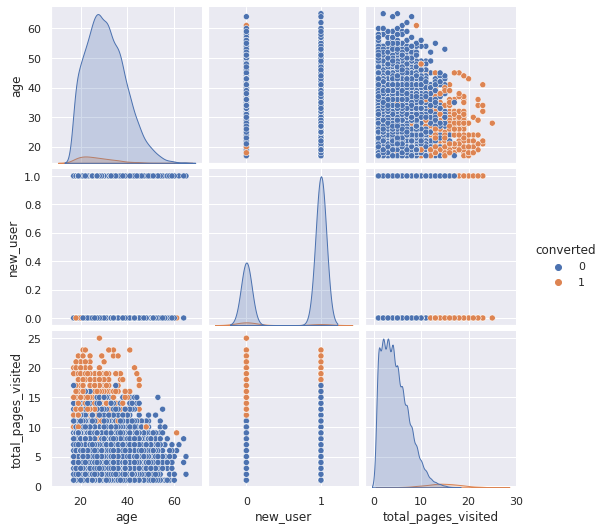

In [14]:
plt.figure(figsize=(10,6))
sns.pairplot( hue='converted', data=data_sample)


At first view, converted users visited more than 13 pages, independently of the user's age

### Relation between total_pages_visited and age

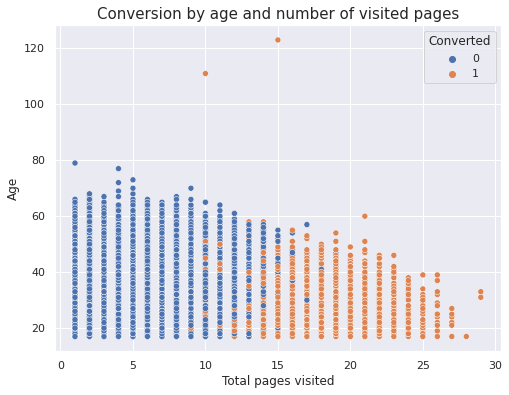

In [15]:
sns.set_theme()
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Conversion by age and number of visited pages', fontdict={'fontname':'DejaVu Sans', 'fontsize':15})
sns.scatterplot(x='total_pages_visited', y='age', hue='converted', data=data, ax=axes);
plt.xlabel('Total pages visited')
plt.ylabel('Age')
plt.legend(title='Converted')
plt.show()

In [16]:
sample = data.sample(10000)

Same graphic than above, but using only matplotlib

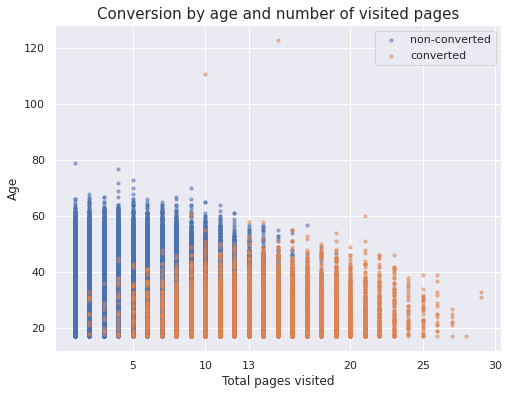

In [5]:
#Another way to visualize Age and Total pages visited using only matplotlib
sns.set_theme()
plt.figure(figsize=(8,6))
converted_points = data[data['converted']==1]
non_converted_points = data[data['converted']==0]
# converted_points = sample[sample['converted']==1]
# non_converted_points = sample[sample['converted']==0]
plt.title('Conversion by age and number of visited pages', fontdict={'fontname':'DejaVu Sans', 'fontsize':15})
plt.scatter(non_converted_points['total_pages_visited'], non_converted_points['age'], label='non-converted', alpha=0.5, s=10)
plt.scatter(converted_points['total_pages_visited'], converted_points['age'], label='converted', alpha=0.5, s=10 )
plt.xticks([5,10,13,20,25, 30])

plt.xlabel('Total pages visited')
plt.ylabel('Age')
plt.legend()
#plt.subplots_adjust(bottom=.25, left=.25)

plt.show()

 It seems that the variable total_pages_visited has an important impact in the conversion rate between ages 20 and 45 aproximately
- From the graphic above, users having visited more than 13 pages have been coverted


## Age distribution of visitors

In [6]:
sns.set_theme(style="ticks", font_scale=1.25)

<Figure size 864x432 with 0 Axes>

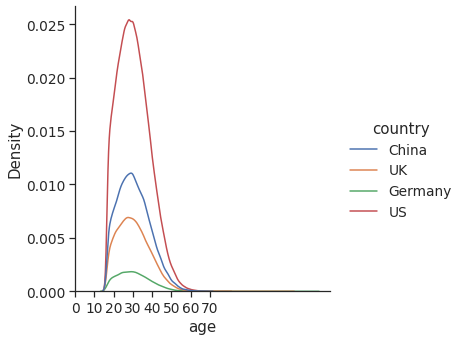

In [7]:
plt.figure(figsize=(12,6))
sns.displot(data, x="age", hue="country", kind='kde')#, palette="icefire")
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.show()

### Conversion per country and total_pages_visited

In [8]:
def describe_per_country(data):
    grouped = data.groupby(['country']).describe()
    print('**total_pages_visited**')
    print(grouped['total_pages_visited'])
    print('\n')
    print('**age**')
    print(grouped['age'])

In [9]:
describe_per_country(data)

**total_pages_visited**
            count      mean       std  min  25%  50%  75%   max
country                                                        
China     69122.0  4.551604  2.805554  1.0  2.0  4.0  6.0  26.0
Germany   11693.0  5.207646  3.782125  1.0  2.0  4.0  7.0  27.0
UK        43641.0  5.078985  3.628525  1.0  2.0  4.0  7.0  27.0
US       160124.0  4.931609  3.428069  1.0  2.0  4.0  7.0  29.0


**age**
            count       mean       std   min   25%   50%   75%    max
country                                                              
China     69122.0  30.664014  8.275166  17.0  24.0  30.0  36.0   69.0
Germany   11693.0  30.457966  8.293478  17.0  24.0  30.0  36.0  123.0
UK        43641.0  30.433675  8.239715  17.0  24.0  30.0  36.0  111.0
US       160124.0  30.564450  8.268073  17.0  24.0  30.0  36.0   79.0


In [11]:
converted_mean = round(data[data['converted']==1]['total_pages_visited'].mean(), 2)
non_converted_mean = round(data[data['converted']==0]['total_pages_visited'].mean(), 2)
print(f'Mean visited pages for converted users:{converted_mean} \nMean visited pages for non converted users:{non_converted_mean}' )

Mean visited pages for converted users:14.56 
Mean visited pages for non converted users:4.55


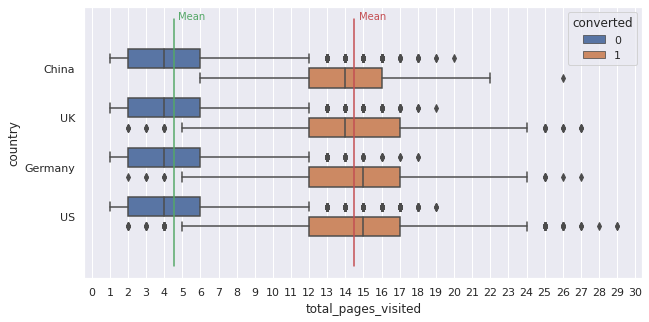

In [12]:
#plt.style.use('default')
sns.set_theme()
plt.figure(figsize=(10,5))
sns.boxplot(y='country', x='total_pages_visited', hue='converted',data=data)
plt.xticks(range(0,31))
plt.plot([14.5, 14.5], [-1, 4], 'r') # Draw a line for the mean of converted people
plt.plot([4.55, 4.55], [4, -1], 'g') # Draw a line for the mean of converted people
plt.text(15.5,-1, 'Mean', ha = 'center', fontsize=10, c='r') # Draw the text for the means
plt.text(5.5,-1, 'Mean', ha = 'center', fontsize=10, c='g') # Draw the text for the means
plt.show()

- In general, for all countries, with 75% of non converted users visited less than 6 pages.
- On average, converted users in China and UK visited 14 pages and US and China visited 15 pages

<class 'matplotlib.axes._subplots.AxesSubplot'>


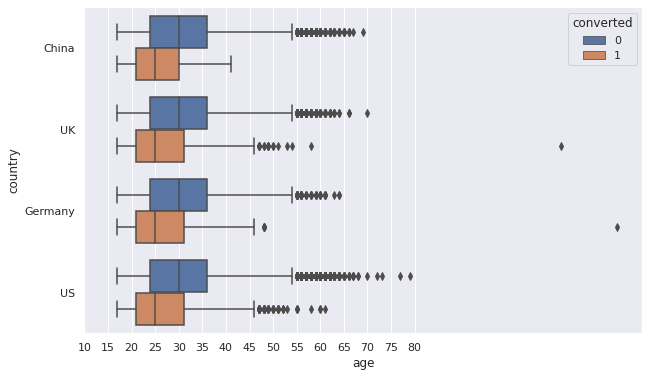

In [13]:
plt.figure(figsize=(10,6))
boxes = sns.boxplot(y='country', x='age', hue='converted',data=data)
plt.xticks(range(10,81,5))
plt.show()

### Conversion per country and total_pages_visited

Text(0.5, 0, 'Conversion')

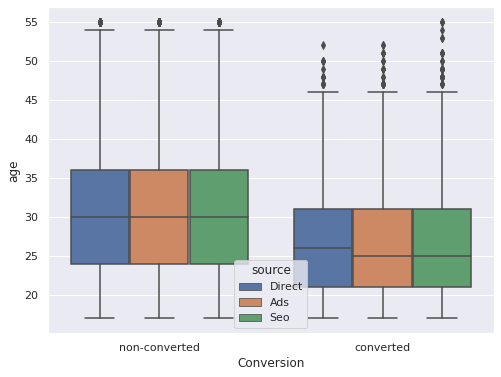

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='converted', y='age',hue='source', data=data[~mask_age_over_55], ax=ax)
ax.set_xticklabels(['non-converted', 'converted'])
ax.set_xlabel('Conversion')

Converted users from a Direct source are slighly older than those converted using other sources (Ads, Seo)

Text(0.5, 1.0, 'PDF Age')

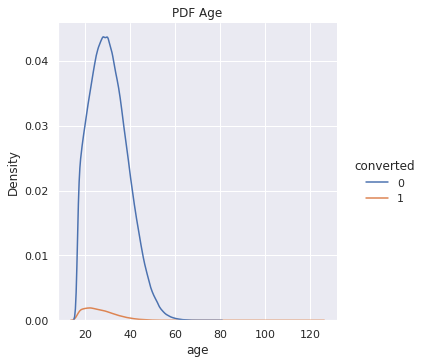

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
sns.displot(data, x="age", hue='converted', kind='kde')
plt.title('PDF Age')

Text(0.5, 1.0, 'PDF Pages visited')

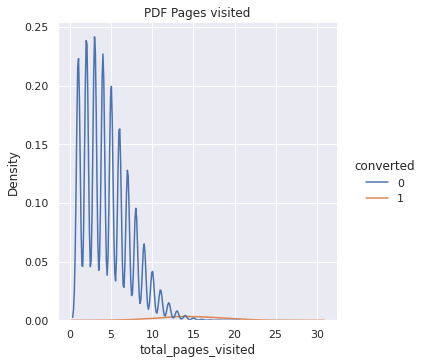

In [ ]:
g = sns.displot(data, x='total_pages_visited', hue="converted", kind='kde')
#g.set_titles("Converted = {col_name}")
plt.title('PDF Pages visited')

In [58]:
print("Botton 10 ages in the dataset")
count_users_by_age = data.groupby('age')[['converted']].count().reset_index()
count_users_by_age.sort_values(by='age', ascending=False).head(10)

Botton 10 ages in the dataset


,age,converted
59,123,1
58,111,1
57,79,1
56,77,1
55,73,1
54,72,1
53,70,2
52,69,1
51,68,2
50,67,5


In [65]:
print("Calculate the Age from which users would be outliers")


Calculate the Age from which users would be outliers


,age
count,284580.000000
mean,30.564203
std,8.266789
min,17.000000
25%,24.000000
50%,30.000000
75%,36.000000
max,123.000000


#### Age

In [ ]:
mask_age_over_55 = data['age'] > 55
mask_age_over_65 = data['age'] > 65
data[mask_age_over_65].groupby('country').count()

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,5,5,5,5,5
Germany,1,1,1,1,1
UK,4,4,4,4,4
US,15,15,15,15,15


### Distribution des ages

In [67]:
df_desc=train_set.describe()
print(df_desc['total_pages_visited'])
iqr = (df_desc.loc['75%', 'total_pages_visited']-df_desc.loc['25%','total_pages_visited']) 
print(f'IQR total_pages_visited={iqr}')
maximum = df_desc.loc['75%', 'total_pages_visited'] + 1.5*iqr
minimum = df_desc.loc['25%', 'total_pages_visited'] - 1.5*iqr

count    227664.000000
mean          4.872817
std           3.338793
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          29.000000
Name: total_pages_visited, dtype: float64
IQR total_pages_visited=5.0


In [68]:
print(f'Outliers visited more than {maximum} pages')
print(f'Outliers visited less thn {minimum} pages')

Outliers visited more than 14.5 pages
Outliers visited less thn -5.5 pages


### Identify outliers for age

In [69]:
print(f'Age statistics')
data.groupby('converted').describe()['age']

Age statistics


,count,mean,std,min,25%,50%,75%,max
converted,,,,,,,,
0,275400.0,30.697422,8.27009,17.0,24.0,30.0,36.0,79.0
1,9180.0,26.567647,7.08539,17.0,21.0,25.0,31.0,123.0


> On average, converted users are **younger** than non converted users

In [115]:
iqr = (df_desc.loc['75%', 'age']-df_desc.loc['25%','age']) 
print(f'IQR age={iqr}')
maximum = df_desc.loc['75%', 'age'] + 1.5*iqr
minimum = df_desc.loc['25%', 'age'] - 1.5*iqr

print(f'Outliers older than {maximum} years old')
print(f'Outliers younger than {minimum} years old')

IQR age=12.0
Outliers older than 54.0 years old
Outliers younger than 6.0 years old


### Remove outliers : Users age > 70 years old

<AxesSubplot:xlabel='converted', ylabel='age'>

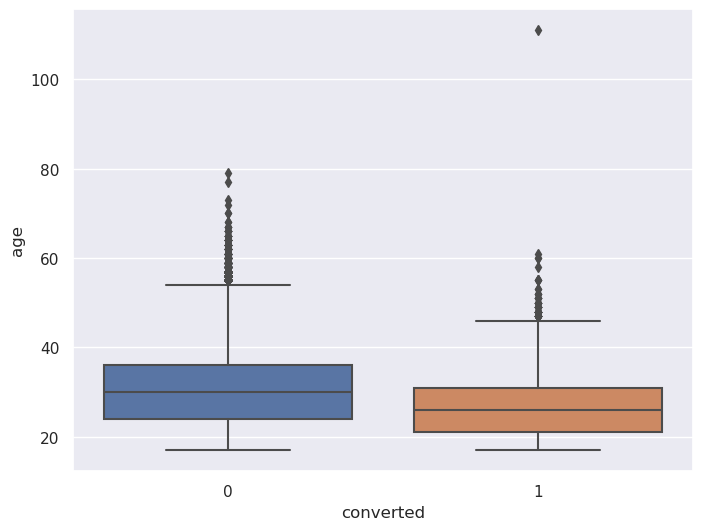

In [116]:
fig, axes = plt.subplots(figsize=(8,6))
sns.boxplot(x='converted', y='age', data=train_set, ax=axes)


In [117]:
mask_outliers_age = train_set['age']>70 # Instead of 54, we're going to use 70 years old
print(f'Users older than 70 years old')
train_set[mask_outliers_age].converted.value_counts()

Users older than 70 years old


0    4
1    1
Name: converted, dtype: int64

In [118]:
print(f'Converted Users having more than 70 years old: {train_set[mask_outliers_age]["converted"].sum()}')
print(f'Representing a percentage of: {np.round(train_set[mask_outliers_age]["converted"].sum()*100/train_set.shape[0], 3)}')


Converted Users having more than 70 years old: 1
Representing a percentage of: 0.0


In [119]:
X_train[X_train['age']>54]

,country,age,new_user,source,total_pages_visited
220338,US,57,1,Seo,4
255147,US,57,1,Direct,4
281831,US,61,1,Seo,3
248445,US,55,1,Direct,5
26653,China,55,0,Seo,3
...,...,...,...,...,...
167292,UK,55,1,Seo,1
147550,UK,59,1,Seo,2
190471,China,57,1,Seo,2
126131,US,55,1,Seo,1


<AxesSubplot:xlabel='converted', ylabel='age'>

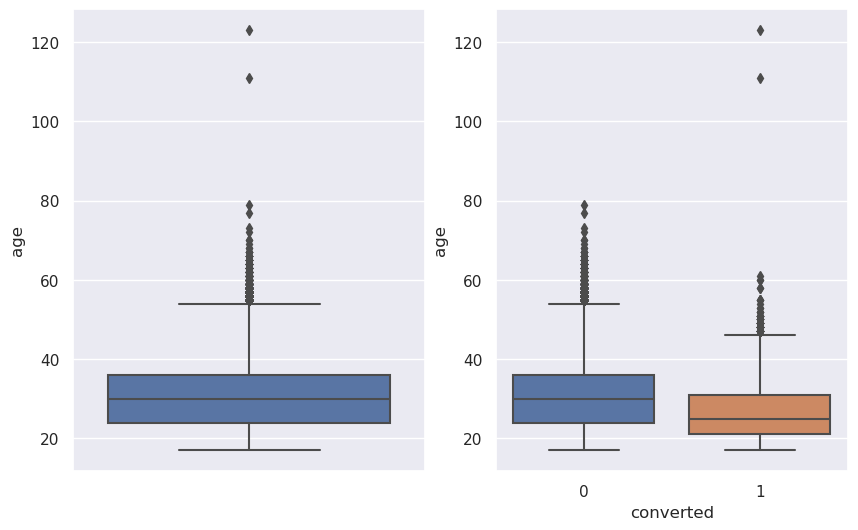

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.boxplot(data=data[['age','converted']], y='age', ax=axes[0])
sns.boxplot(data=data[['age','converted']], x='converted', y='age', ax=axes[1])


In [121]:
X_train[X_train['age']>70].index
X_train = X_train.drop(index=X_train[X_train['age']>60].index, axis=0)


In [122]:
X_train['age'].value_counts().sort_values(ascending=False)[0:10]

28    10511
30    10342
29    10223
27    10101
26    10090
31     9843
25     9736
32     9636
24     9325
33     9149
Name: age, dtype: int64

Top 10 ages in the dataset: 24 - 33 years old

In [123]:
data[data['converted'] == 1][['country']].value_counts().sort_values(ascending=False)
(data.groupby('country')['country'].count()*100/data.shape[0]).sort_values(ascending=False)

country
US         56.266779
China      24.289128
UK         15.335231
Germany     4.108862
Name: country, dtype: float64

<b> Proportion converted users in each country</b>

In [124]:
data.groupby(['country'])['converted'].agg('sum') * 100 /data['converted'].sum()

country
China       0.969499
Germany     7.952070
UK         24.956427
US         66.122004
Name: converted, dtype: float64

In [125]:
### TODO un piechart

<b> Conversion rate per country </b>

In [126]:
data.groupby(['country'])['converted'].agg('sum') * 100 /data.groupby(['country'])['converted'].count()

country
China      0.128758
Germany    6.243051
UK         5.249651
US         3.790812
Name: converted, dtype: float64

## Pre-processing pipeline

### Re-split data with all features

All features <br>
Test_set ratio : 20% 

In [70]:
target_label = ['converted']
X = data.drop(target_label, axis=1)
y = data[target_label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Create transformation pipeline

In [128]:
num_features = X_train.select_dtypes(include=np.number).columns.to_list()
cat_features = X_train.select_dtypes(include=object).columns.to_list()
# Transformer for extra features from Date
# transformer for numerical features
num_transformer = Pipeline([
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ])
# transformer for categorical features
cat_transformer = Pipeline([
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
        ('categoricals', cat_transformer, cat_features),
        ('numericals', num_transformer, num_features)
    ],
    remainder = 'drop'
)

In [129]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5),
    LinearSVC(),
    #NuSVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, ),
    #GradientBoostingClassifier()
    ]


In [130]:
y_train.ravel()

array([0, 0, 0, ..., 0, 0, 0])

### Train models to pick 1-3 best performances

In [71]:
headers = ['classifier', 'train_precision', 'train_recall', 'train_f1','test_precision', 'test_recall', 'test_f1']
values = list()
res_pipelines = list()
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessing', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train.ravel())
    
    p, r, f1 = predict_compare(pipe, X_train, y_train.ravel())
    p_test, r_test, f1_test = predict_compare(pipe, X_test, y_test.ravel())
    values.append([str(classifier), p, r, f1, p_test, r_test, f1_test])
    #print("model score: %.3f" % pipe.score(X_test, y_test))   
    
#print(values)
clf_perf = pd.DataFrame(values, columns=headers)
clf_perf

NameError: name 'classifiers' is not defined

> Since test f1_scores are not that different between models and RandomForest has the characteristic of having the calculation of feature importance -> I choose these model to apply SearchCV <br>
However, for future enhancements on the model, searching for good parameters will be done for AdaBoost and LogisticRegression

### Feature importances from RandomForest classifier

In [132]:
cat_encoder_attribs = np.asarray(pipe.named_steps['preprocessing'].named_transformers_['categoricals'].named_steps['onehot'].categories_, dtype=object)

In [133]:
cat_attribs = np.concatenate([cat_list for cat_list in cat_encoder_attribs])

In [134]:
all_features = np.concatenate([cat_attribs, num_features])
all_features

array(['China', 'Germany', 'UK', 'US', 'Ads', 'Direct', 'Seo', 'age',
       'new_user', 'total_pages_visited'], dtype=object)

In [135]:
pipe.named_steps['preprocessing']

ColumnTransformer(transformers=[('categoricals',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['country', 'source']),
                                ('numericals',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'new_user', 'total_pages_visited'])])

In [136]:
sorted(zip(pipe.steps[1][1].feature_importances_, all_features), reverse=True)

[(0.6110039, 'total_pages_visited'),
 (0.1650179, 'China'),
 (0.13887408, 'new_user'),
 (0.020104991, 'US'),
 (0.017243225, 'age'),
 (0.010911038, 'Direct'),
 (0.010494949, 'Germany'),
 (0.01023513, 'UK'),
 (0.008662763, 'Ads'),
 (0.0074520144, 'Seo')]

> The most important features are total_pages_visited, China, new_user <br>
> Age is not that important as I thought initially <br>
> Finally, source has very small weight (almost zero) on the result <br>